For having a meaningfull result which is similar to real life scenario

Rankings will be weighed regarding to tv revenues. Normally, there are bunch of different factors such as selling ticket participation rate

https://www.aktifbank.com.tr/Documents/FOOTBALL-ECONOMY-REPORT.pdf
https://www.aktifbank.com.tr/en/siteabout/pressroom/news/Pages/The-Attendance-Rate-Increased-By-43-Percent-In-Spor-Toto-Super-Lig.aspx


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup

#%matplotlib notebook

In [2]:
transfermarket_links_dict = {'Galatasaray': 'https://www.transfermarkt.us/galatasaray-istanbul/alletransfers/verein/141', 
                             'Fenerbahçe': 'https://www.transfermarkt.us/fenerbahce-istanbul/alletransfers/verein/36',
                             'Beşiktaş': 'https://www.transfermarkt.us/besiktas-istanbul/alletransfers/verein/114',
                             'İstanbul Başakşehir': 'https://www.transfermarkt.us/istanbul-buyuksehir-belediyespor/alletransfers/verein/6890'
                            }

In [3]:
for team_web in transfermarket_links_dict:
    print(transfermarket_links_dict[team_web])

https://www.transfermarkt.us/galatasaray-istanbul/alletransfers/verein/141
https://www.transfermarkt.us/fenerbahce-istanbul/alletransfers/verein/36
https://www.transfermarkt.us/besiktas-istanbul/alletransfers/verein/114
https://www.transfermarkt.us/istanbul-buyuksehir-belediyespor/alletransfers/verein/6890


In [4]:
start_year = 2008
end_year = 2018
# Get data from Super Lig Wikipedia Page. This page contains a table in which
# there is reference for different years. The first URL command opens this page and gets requested seosons links
superligurl = 'https://en.wikipedia.org/wiki/S%C3%BCper_Lig'
response = requests.get(superligurl)
soup = BeautifulSoup(response.text, 'html.parser')

# The mentioned hrefs are stored as 'navbox-list navbox-odd hlist' class
mydivs = soup.findAll("td", {"class": "navbox-list navbox-odd hlist"})
table_href = mydivs[1].find_all('a')
# Pandas dataframe is created from the entered years links
df_table_href = pd.DataFrame(columns=['Season','links'])
for n in range(len(table_href)):
    df_table_href.loc[n,'Season'] = table_href[n].get_text()
    df_table_href.loc[n,'Year'] = int(table_href[n].get_text().split('–')[0])
    df_table_href.loc[n,'links'] = 'https://en.wikipedia.org' + table_href[n].get('href')
df_table_href.set_index('Year',inplace=True)
df_table_href=df_table_href.loc[start_year:end_year]

In [5]:
# Getting season scores from the links table that have been created

# interested columns in the wikipedia table
table_columns = ['Pos', 'Team', 'Pld', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Year']
df_table = pd.DataFrame(columns=table_columns)
#df_table.set_index(['Year'], drop=True, inplace=True)

# this loop iterates over pages and extract the season table information from each page
for year in range(start_year,end_year):
    url = df_table_href.loc[year,'links']
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    #print(soup.prettify())
    wikitable = soup.findAll('table',{"class": "wikitable"})
    df_read_wikitable=pd.read_html(str(wikitable))
    for dataframe in df_read_wikitable:
        columnsnames = list(dataframe.columns)
        if (columnsnames.count('W')>0) and (columnsnames.count('L')>0) and (columnsnames.count('Pts')>0):
            #update column names for appending dataset to 
            dataframe.columns = table_columns
            dataframe['Year'] = year
            #print(dataframe)
            df_table = pd.concat( [df_table ,dataframe[table_columns]],ignore_index=True)

In [6]:
def clean_name(df,colname):
    #df.where(df['Pos'] == 'Qualification to UEFA Cup second qualifying round').dropna(inplace=True)
    for index,row in df.iterrows():
        df.loc[index,colname] = re.search(u"[\w\s+−]*[\w$]",str(row[colname]))[0] 
    return df

In [7]:
table_columns = ['Pos', 'Team', 'Pld', 'W', 'D', 'L', 'GF', 'GA', 'Pts', 'Year']
df_cleaned = df_table.copy()
for columns in table_columns:
    df_cleaned = clean_name(df_cleaned,columns)
    
integer_columns = ['Pos','Pld', 'W', 'D', 'L', 'GF', 'GA', 'Pts', 'Year']
df_cleaned[integer_columns] = df_cleaned[integer_columns].astype('int32')

In [8]:
## Adapting Names of the teams
df_cleaned.loc[(df_cleaned['Team'] == 'Mersin İdman Yurdu'),'Team'] = 'Mersin İdmanyurdu'
df_cleaned.loc[(df_cleaned['Team'] == 'Ankaragücü'),'Team'] = 'MKE Ankaragücü'
df_cleaned.loc[(df_cleaned['Team'] == 'Karabükspor'),'Team'] = 'Kardemir Karabükspor'
df_cleaned.loc[(df_cleaned['Team'] == 'İstanbul B'),'Team'] = 'İstanbul Başakşehir'

In [9]:
interested_years = list(range(start_year,end_year))
interested_season_dict = dict()
for year in interested_years:
    interested_season_dict[year] = str(year)[2:] + '/'+ str(year+1)[2:]
    
df_cleaned['Season']= df_cleaned.apply(lambda x: interested_season_dict[x.Year], axis=1)

In [10]:
istanbul_teams= ['Galatasaray','Fenerbahçe', 'Beşiktaş', 'İstanbul Başakşehir']
df_cleaned['Season']= df_cleaned.apply(lambda x: interested_season_dict[x.Year], axis=1)
pivot_leaguetable = df_cleaned.pivot_table(values=['Pos','W','D','L','Pts'], index='Team', 
                                     columns='Season',aggfunc='first', fill_value=0)
pivot_leaguetable = pivot_leaguetable.loc[istanbul_teams]
pivot_leaguetable.head()

D                                                  \
Season              08/09 09/10 10/11 11/12 12/13 13/14 14/15 15/16 16/17   
Team                                                                        
Galatasaray             7     7     4     8     8    11     5    12     4   
Fenerbahçe              7     5     4     8     7     5     8     8    10   
Beşiktaş                8    10     9    10    10    11     6     4     8   
İstanbul Başakşehir     6     8     6     8     9     0    14    11    10   

                           ...     W                                      \
Season              17/18  ... 08/09 09/10 10/11 11/12 12/13 13/14 14/15   
Team                       ...                                             
Galatasaray             3  ...    18    19    14    23    21    18    24   
Fenerbahçe              9  ...    18    23    26    20    18    23    22   
Beşiktaş                8  ...    21    18    15    15    16    17    21   
İstanbul Başakşehir     6  ...    12    16    12    14     9     0    15   

                                       
Season              15/16 16/17 17/18  
Team                                   
Galatasaray            13    20    24  
Fenerbahçe             22    18    21  
Beşiktaş               25    23    21  
İstanbul Başakşehir    16    21    22  

[4 rows x 50 columns]

In [11]:
#transfer_col  = ['Origin_Club','Player','Related_Club','Fee','Status','Season']
#df_transfers = pd.DataFrame(columns= transfer_col)

transfer_col  = ['Origin_Club','Total Fee','Status','Season']
df_trans_seasons = pd.DataFrame(columns= transfer_col)

headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

for team in transfermarket_links_dict:
    transfermarket_resp = requests.get(transfermarket_links_dict[team], headers=headers)
    soup = BeautifulSoup(transfermarket_resp.content, 'html.parser')
    transferlist = soup.find_all("div", {"class": "box"})
    for n in range(len(transferlist)): # first item could be a empty box, so skip to skip item start from 1
        try:
            season_name = transferlist[n].find('h2').text.split()
            season_feesum= transferlist[n].tfoot.td.text
            single_season = pd.Series([team,season_feesum, season_name[0],season_name[1]], index = transfer_col)
            df_trans_seasons= df_trans_seasons.append(single_season, ignore_index=True)
        except: continue           
            #season_soup = transferlist[n].tbody.find_all("tr")
        #except: continue
        #for item in season_soup:
            #player = item.select('.hauptlink')[0].a.text
            #club = item.select('.no-border-links')[0].a.text
            #fee = item.select('.rechts')[0].get_text()
            #single_transfer = pd.Series([team,player,club,fee, season_name[0],season_name[1]], index = transfer_col)
            #df_transfers= df_transfers.append(single_transfer, ignore_index=True)

In [12]:
def clean_fee(df):
    for index,row in df.iterrows():
        fee_text = row['Total Fee']
        fee_value = re.findall(u'[0-9.]*',fee_text)
        if re.search('Th.$', fee_text):
            df.loc[index,'Total Fee'] =  float(fee_value[1])/1e3
        elif re.search('m$', fee_text):
            df.loc[index,'Total Fee'] =  float(fee_value[1])
        else:
            df.loc[index,'Total Fee'] =  0
    return df

df_trans_seasons = clean_fee(df_trans_seasons)

In [13]:
df_trans_seasons.head()

,Origin_Club,Total Fee,Status,Season
0,Galatasaray,0.743,Arrivals,20/21
1,Galatasaray,1.89,Departures,20/21
2,Galatasaray,10.93,Arrivals,19/20
3,Galatasaray,12.06,Departures,19/20
4,Galatasaray,31.38,Arrivals,18/19


In [14]:
pivot_transfers = df_trans_seasons.pivot_table(values='Total Fee', index=['Origin_Club','Status'], 
                                     columns='Season',aggfunc='first', fill_value=0)
pivot_transfers.head()

Season                   00/01  01/02  02/03  03/04  04/05  05/06  06/07  \
Origin_Club Status                                                         
Beşiktaş    Arrivals    14.580   9.19   9.54   5.06  15.07   9.98  17.55   
            Departures   0.633  11.83   1.10   6.88   1.10  11.83   3.91   
Fenerbahçe  Arrivals    25.040   3.91  13.59   8.03  17.64  10.12  27.17   
            Departures  17.600   0.00   5.72   0.77   0.00   0.00  13.20   
Galatasaray Arrivals    30.310   5.34  13.53   6.77   7.87   4.68   4.18   

Season                  07/08  08/09  09/10  ...  90/91  91/92  92/93  93/94  \
Origin_Club Status                           ...                               
Beşiktaş    Arrivals    11.72  18.21  26.32  ...      0      0  0.400  0.000   
            Departures   2.53   0.88   0.11  ...      0      0  0.000  0.000   
Fenerbahçe  Arrivals     8.69  22.55  34.32  ...      0      0  0.550  1.870   
            Departures   0.00   0.00   4.29  ...      0      0  0.000  0.000   
Galatasaray Arrivals    15.40  13.20  18.08  ...      0      0  0.275  0.715   

Season                  94/95  95/96  96/97  97/98  98/99  99/00  
Origin_Club Status                                                
Beşiktaş    Arrivals     3.85   1.65   2.20   2.48   7.15   4.18  
            Departures   0.00   0.00   3.82   5.50   0.00   0.00  
Fenerbahçe  Arrivals     0.55  11.00   5.17   0.99  19.47  17.27  
            Departures   0.00   0.00   2.20   0.33  13.64  24.28  
Galatasaray Arrivals     0.00   4.57   8.25   4.95   7.48   0.00  

[5 rows x 108 columns]

In [15]:
pivot_transfers = pivot_transfers[list(interested_season_dict.values())]

In [16]:
pivot_arrivals = pivot_transfers.groupby('Status').get_group('Arrivals')
pivot_arrivals.reset_index(level=1, drop=True, inplace= True)
pivot_arrivals.head()

Season,08/09,09/10,10/11,11/12,12/13,13/14,14/15,15/16,16/17,17/18
Origin_Club,,,,,,,,,,
Beşiktaş,18.21,26.32,14.41,15.35,4.40,15.350,15.90,15.35,16.61,14.03
Fenerbahçe,22.55,34.32,25.96,38.83,37.29,33.280,0.00,46.94,7.81,21.65
Galatasaray,13.20,18.08,32.45,25.96,35.26,49.320,15.40,12.14,22.77,49.28
İstanbul Başakşehir,0.66,0.00,1.10,5.28,4.09,0.275,2.95,2.75,10.90,4.07


Traceback (most recent call last):
  File "C:\Users\Tarcin\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\Tarcin\anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


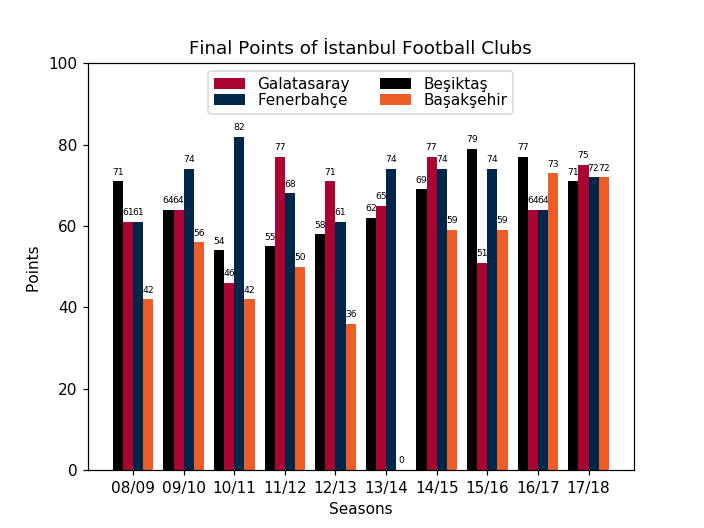

In [24]:
%matplotlib notebook

pivot_points = pivot_leaguetable['Pts']
labels = list(pivot_points.columns)
gs_pts = pivot_points.loc['Galatasaray'].values.tolist()
fb_pts = pivot_points.loc['Fenerbahçe'].values.tolist() 
bjk_pts = pivot_points.loc['Beşiktaş'].values.tolist()
ibb_pts = pivot_points.loc['İstanbul Başakşehir'].values.tolist() 

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, gs_pts, width, label='Galatasaray', color='#A90432')
rects2 = ax.bar(x + width/2, fb_pts, width, label='Fenerbahçe', color='#002749')
rects3 = ax.bar(x - 1.5*width, bjk_pts, width, label='Beşiktaş', color='#000000')
rects4 = ax.bar(x + 1.5*width, ibb_pts, width, label='Başakşehir', color='#ed5e27')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Points ')
ax.set_xlabel('Seasons')
ax.set_title('Final Points of İstanbul Football Clubs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2,labelspacing=0.05, loc='upper center')
plt.ylim(0, 100)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

#fig.tight_layout()

plt.savefig('final_points.png')

In [18]:
x = pivot_transfers.loc[('Fenerbahçe','Arrivals')].values[:2]
x

array([22.55, 34.32])

<IPython.core.display.Javascript object>


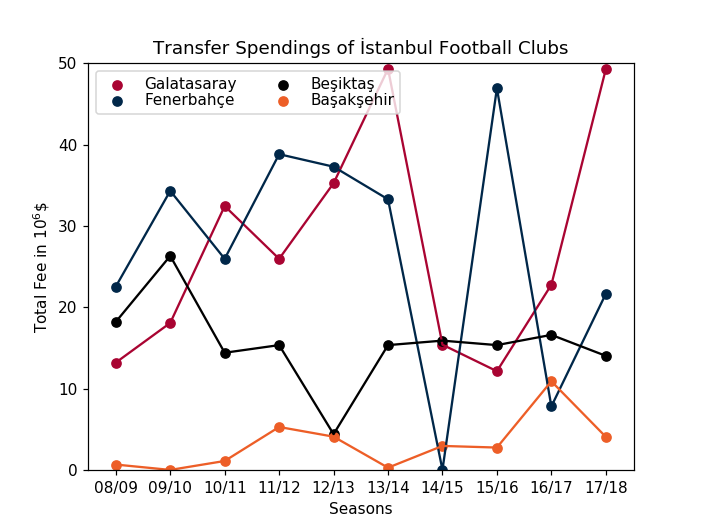

In [23]:
%matplotlib notebook

import matplotlib.animation as animation

labels = list(pivot_transfers.columns)

def update(curr):
    # check if animation is at the last frame, and if so, stop the animation a
    if curr == len(labels): 
        a.event_source.stop()
    plt.cla()
    x = np.arange(len(labels))[:curr]  # the label locations
    gs_trns = pivot_transfers.loc[('Galatasaray','Arrivals')].values.tolist()[:curr]
    fb_trns = pivot_transfers.loc[('Fenerbahçe','Arrivals')].values.tolist()[:curr]
    bjk_trns = pivot_transfers.loc[('Beşiktaş','Arrivals')].values.tolist()[:curr]
    ibb_trns = pivot_transfers.loc[('İstanbul Başakşehir','Arrivals')].values.tolist()[:curr] 
    ax = plt.gca()
    
    ax.scatter(x, gs_trns, label='Galatasaray', color='#A90432')
    ax.plot(x, gs_trns, color='#A90432')
    ax.scatter(x, fb_trns, label='Fenerbahçe', color='#002749')
    ax.plot(x, fb_trns, color='#002749')
    ax.scatter(x, bjk_trns, label='Beşiktaş', color='#000000')
    ax.plot(x, bjk_trns,color='#000000')
    ax.scatter(x, ibb_trns, label='Başakşehir', color='#ed5e27')
    ax.plot(x, ibb_trns, color='#ed5e27')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(r'Total Fee in $10^6$\$ ')
    ax.set_xlabel('Seasons')
    ax.set_title('Transfer Spendings of İstanbul Football Clubs')
    
    x = np.arange(len(labels)) # the label locations
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(ncol=2,labelspacing=0.05, loc='upper left')
    plt.ylim(0, 50)

#fig.tight_layout()
#plt.show()

fig = plt.figure()
a = animation.FuncAnimation(fig, update, interval=300)
plt.savefig('transfers.png')

<IPython.core.display.Javascript object>


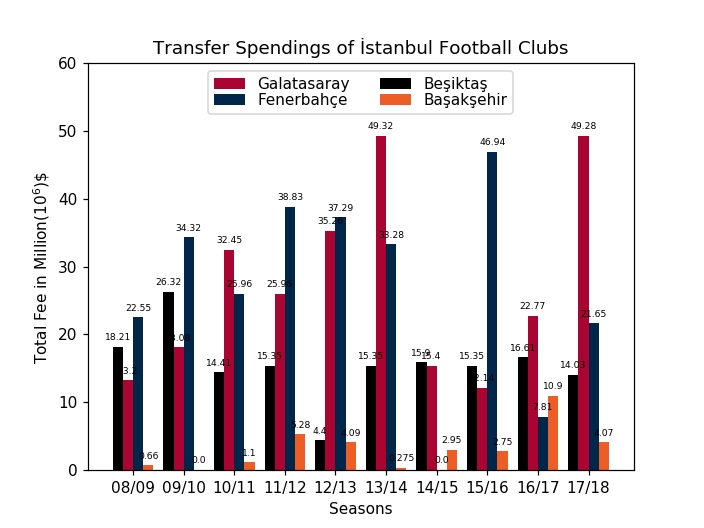

In [27]:
%matplotlib notebook

pivot_points = pivot_leaguetable['Pts']
labels = list(pivot_points.columns)

gs_trns = pivot_transfers.loc[('Galatasaray','Arrivals')].values.tolist()
fb_trns = pivot_transfers.loc[('Fenerbahçe','Arrivals')].values.tolist()
bjk_trns = pivot_transfers.loc[('Beşiktaş','Arrivals')].values.tolist()
ibb_trns = pivot_transfers.loc[('İstanbul Başakşehir','Arrivals')].values.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, gs_trns, width, label='Galatasaray', color='#A90432')
rects2 = ax.bar(x + width/2, fb_trns, width, label='Fenerbahçe', color='#002749')
rects3 = ax.bar(x - 1.5*width, bjk_trns, width, label='Beşiktaş', color='#000000')
rects4 = ax.bar(x + 1.5*width, ibb_trns, width, label='Başakşehir', color='#ed5e27')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Total Fee in Million($10^6$)\$ ')
ax.set_xlabel('Seasons')
ax.set_title('Transfer Spendings of İstanbul Football Clubs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2,labelspacing=0.05, loc='upper center')
plt.ylim(0, 60)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

#fig.tight_layout()

plt.savefig('final_transfersbars.png')